# Flame Speed with Sensitivity Analysis

In this example we simulate a freely-propagating, adiabatic, 1-D flame and
* Calculate its laminar burning velocity
* Perform a sensitivity analysis of its kinetics

The figure below illustrates the setup, in a flame-fixed co-ordinate system. The reactants enter with density $\rho_{u}$, temperature $T_{u}$ and speed $S_{u}$. The products exit the flame at speed $S_{b}$, density $\rho_{b}$ and temperature $T_{b}$.

<img src="images/flameSpeed.png" alt="Freely Propagating Flame" style="width: 300px;"/>

### Import Modules

In [1]:
from __future__ import print_function
from __future__ import division

import cantera as ct
import numpy as np

print("Running Cantera Version: " + str(ct.__version__))

Running Cantera Version: 2.3.0a3


### Define the reactant conditions, gas mixture and kinetic mechanism associated with the gas

In [2]:
#Inlet Temperature in Kelvin and Inlet Pressure in Pascals
#In this case we are setting the inlet T and P to room temperature conditions
To = 300
Po = 101325

#Define the gas-mixutre and kinetics
#In this case, we are choosing a GRI3.0 gas
gas = ct.Solution('gri30.cti')

# Create a stoichiometric CH4/Air premixed mixture 
gas.set_equivalence_ratio(1.0, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

### Define flame simulation conditions

In [3]:
# Domain width in metres
width = 0.014

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Define tolerances for the solver
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

# Define logging level
loglevel = 1

### Solve

In [4]:
flame.solve(loglevel=loglevel, auto=True)
Su0 = flame.u[0]
print("Flame Speed is: {:.2f} cm/s".format(Su0*100))

#Note that the variable Su0 will also be used downsteam in the sensitivity analysis


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.446
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0003649      4.417
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.871e-05      5.791
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.601e-05      5.905
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0009998      4.303
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..............................................................................
grid refinement disabled.

******************** Solving with grid refinement enabled ********************

.................

### Plot figures

Check and see if all has gone well. Plot temperature and species fractions to see

In [5]:
# Import plotting modules and define plotting preference
import matplotlib.pylab as plt
%matplotlib notebook

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (8,6)

# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')

plt.rcParams['figure.autolayout'] = True

#### Temperature Plot

<IPython.core.display.Javascript object>


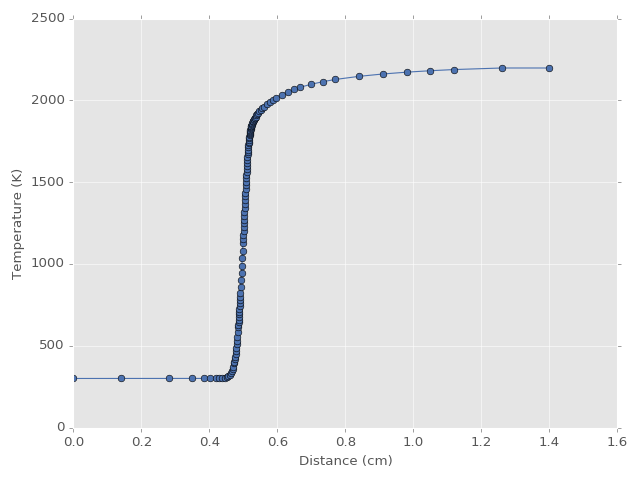

In [6]:
plt.figure()

plt.plot(flame.grid*100, flame.T, '-o')
plt.xlabel('Distance (cm)')
plt.ylabel('Temperature (K)');

#### Major species' plot

<IPython.core.display.Javascript object>


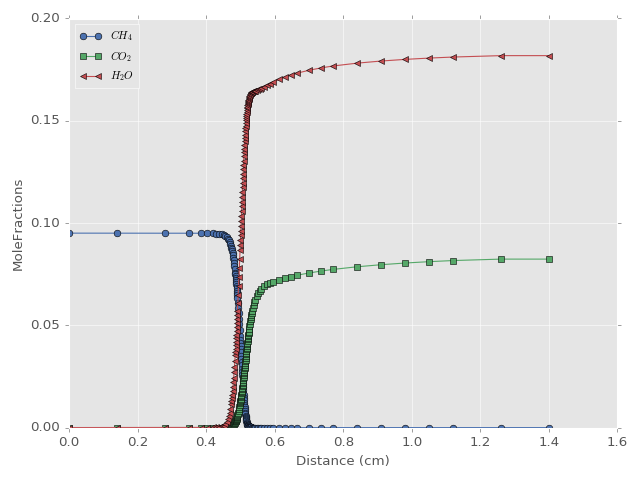

In [7]:
"""
# To plot species, we first have to identify the index of the species in the array
# For this, cut & paste the following lines and run in a new cell to get the index
for i, specie in enumerate(gas.species()):
    print(str(i) + '. ' + str(specie))
"""

# Extract concentration data
X_CH4 = flame.X[13]
X_CO2 = flame.X[15]
X_H2O = flame.X[5]

plt.figure()

plt.plot(flame.grid*100, X_CH4, '-o', label=r'$CH_{4}$')
plt.plot(flame.grid*100, X_CO2, '-s', label=r'$CO_{2}$')
plt.plot(flame.grid*100, X_H2O, '-<', label=r'$H_{2}O$')

plt.legend(loc=2)
plt.xlabel('Distance (cm)')
plt.ylabel('MoleFractions');

## Sensitivity Analysis

See which reactions effect the flame speed the most

### Import a data frame module. This simplifies the code

In [8]:
import pandas as pd

In [9]:
# Create a dataframe to store sensitivity-analysis data
sensitivities = pd.DataFrame(data=[], index=gas.reaction_equations(range(gas.n_reactions)))

### Compute sensitivities

In [10]:
# Set the value of the perturbation
dk = 1e-2

# Create an empty column to store the sensitivities data
sensitivities["baseCase"] = ""

In [11]:
for m in range(gas.n_reactions):
    gas.set_multiplier(1.0) # reset all multipliers                                                                     
    gas.set_multiplier(1+dk, m) # perturb reaction m   
    
    # Always force loglevel=0 for this
    flame.solve(loglevel=0)
    
    # The new flame speed
    Su = flame.u[0]
    
    sensitivities["baseCase"][m] = (Su-Su0)/(Su0*dk)

# This step is essential, otherwise the mechanism will have been altered
gas.set_multiplier(1.0)

In [12]:
sensitivities.head()

,baseCase
2 O + M <=> O2 + M,0.00154932
H + O + M <=> OH + M,0.00108092
H2 + O <=> H + OH,0.0250887
HO2 + O <=> O2 + OH,0.00304705
H2O2 + O <=> HO2 + OH,0.000738241


### Make plots

<IPython.core.display.Javascript object>


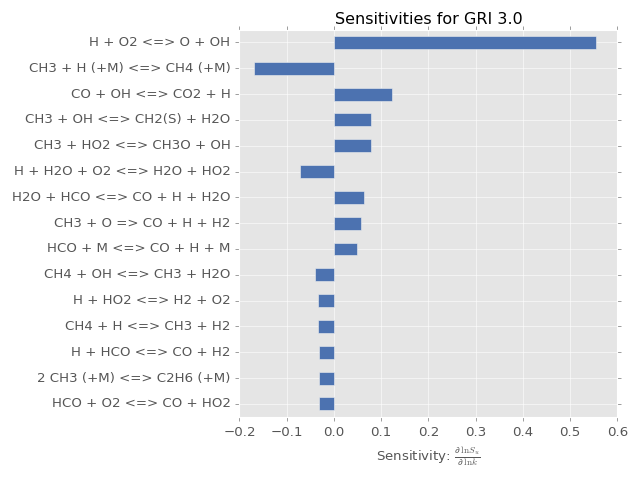

In [13]:
# Reaction mechanisms can contains thousands of elementary steps. Choose a threshold
# to see only the top few
threshold = 0.03

firstColumn = sensitivities.columns[0]

# For plotting, collect only those steps that are above the threshold
# Otherwise, the y-axis gets crowded and illegible
sensitivitiesSubset = sensitivities[sensitivities[firstColumn].abs() > threshold]
indicesMeetingThreshold = sensitivitiesSubset[firstColumn].abs().sort_values(ascending=False).index
sensitivitiesSubset.loc[indicesMeetingThreshold].plot.barh(title="Sensitivities for GRI 3.0",
                                                          legend=None)
plt.gca().invert_yaxis()

plt.rcParams.update({'axes.labelsize': 20})
plt.xlabel(r'Sensitivity: $\frac{\partial\:\ln{S_{u}}}{\partial\:\ln{k}}$');

# Uncomment the following to save the plot. A higher than usual resolution (dpi) helps
# plt.savefig('sensitivityPlot', dpi=300)